# Оптимизация производственных расходов металлургического комбината

На вход предоставлено семь датасетов с информацией о технологических процессах на металлургическом комбинате ООО «Так закаляем сталь»

Целью работы является построение модели для предсказания температуры стали

Планируется разбить работу на _ шагов (будем добавлять по мере прохождения проекта):

 - [План работы](#part_1)
 - [Изучение данных](#part_2)
 - [Подготовка данных](#part_3) 
 - [Обучение моделей](#part_4)

## План работы <a name="part_1"></a>

Планируется решить задачу с помощью нескольких этапов:

- Изучение данных

Необходимо просмотреть данные на предметы пропусковЮ дубликатов, аномалий

- Подготовка данных к обучению модели

Заполнение пропущенных данных, обработка всех найденных сложностей

- Обучение модели

Поиск оптимальной модели, подбор параметров

- Выводы

Составление отчета о проделанной работе

## Изучение данных <a name="part_2"></a>

In [1]:
!pip install lightgbm
!pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor as cbr
from catboost import Pool, cv

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Импортируем все необходимые библиотеки, загружаем отсутствующие

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Будем идти по порядку и сначала рассмотрим данные об электродах

In [3]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
display(data_arc.head())
data_arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [5]:
data_arc.columns = ['key','start','finish','real_power','react_power']

Переименуем колонки, чтобы избавиться от кириллицы, лишнего форматирования и пробелов. Впредь будем делать так во всех датафреймах

In [6]:
data_arc['start'] = pd.to_datetime(data_arc['start'], format='%Y-%m-%d %H:%M:%S')
data_arc['finish'] = pd.to_datetime(data_arc['finish'], format='%Y-%m-%d %H:%M:%S')

Переводим колонки с датами и временем в формат **datetime**. Это так же встречается нам не в последний раз

In [7]:
data_arc[data_arc['react_power']<0]

,key,start,finish,real_power,react_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Присутствует одно явно аномальное значение, обнаруженное с помощью метода **describe**. Отметим себе и займемся немного позже

Далее будем рассматривать данные о сыпучих материалах (их объемах и временных параметрах)

In [8]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [9]:
display(data_bulk.head())
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [10]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [11]:
data_bulk.columns = ['key','bulk1','bulk2','bulk3','bulk4','bulk5','bulk6',
                          'bulk7','bulk8','bulk9','bulk10','bulk11','bulk12','bulk13','bulk14','bulk15']

data_bulk_time.columns = ['key','bulk1','bulk2','bulk3','bulk4','bulk5','bulk6',
                          'bulk7','bulk8','bulk9','bulk10','bulk11','bulk12','bulk13','bulk14','bulk15'] 
for i in range(1,16):
    bulk = 'bulk'+str(i)
    data_bulk_time[bulk] = pd.to_datetime(data_bulk_time[bulk], format='%Y-%m-%d %H:%M:%S')

In [12]:
display(data_bulk_time.head())
display(data_bulk.head())

,key,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Переименовали колонки, перевели типы данных в **datetime**

Рассмотрим данные о продувке сплава газом

In [13]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [14]:
display(data_gas.head())
data_gas.describe()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [15]:
data_gas.columns = ['key','gas']
display(data_gas.head())

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Переименовали столбцы для удобства

## Подготовка данных <a name="part_3"></a>

Рассмотрим данные о результатах измерений температуры

In [16]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [17]:
display(data_temp.head())
data_temp.describe()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [18]:
data_temp.duplicated().sum()

0

In [19]:
data_temp.columns = ['key', 'time', 'temperature']
data_temp.dropna(subset=['temperature'], inplace=True)
data_temp['time'] = pd.to_datetime(data_temp['time'], format='%Y-%m-%d %H:%M:%S')
data_temp['temperature'] = data_temp['temperature'].astype('int64')

Переименовали колонки, удалил данные без замеров температуры, с такими ничего не построим

Дополнительно перевели типы данных в удобные нам

In [21]:
display(data_temp.head())
data_temp.info()

,key,time,temperature
0,1,2019-05-03 11:16:18,1571
1,1,2019-05-03 11:25:53,1604
2,1,2019-05-03 11:29:11,1618
3,1,2019-05-03 11:30:01,1601
4,1,2019-05-03 11:30:39,1613


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key            13006 non-null int64
time           13006 non-null datetime64[ns]
temperature    13006 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 406.4 KB


In [22]:
data_temp_timelag = data_temp.pivot_table(index='key',values='time', aggfunc=[lambda x: len(x.unique()), min, max])
data_temp_timelag['timelag'] = data_temp_timelag['max'] - data_temp_timelag['min']
data_temp_timelag['timelag_sec'] = data_temp_timelag['timelag'].dt.total_seconds().astype('int64')

data_temp_timelag.columns = ['temp_count','time_first','time_last','temp_timelag','temp_timelag_sec']
data_temp_timelag.reset_index(inplace=True)
display(data_temp_timelag.head())

,key,temp_count,time_first,time_last,temp_timelag,temp_timelag_sec
0,1,5,2019-05-03 11:16:18,2019-05-03 11:30:39,00:14:21,861
1,2,6,2019-05-03 11:37:27,2019-05-03 11:59:12,00:21:45,1305
2,3,5,2019-05-03 12:13:17,2019-05-03 12:34:57,00:21:40,1300
3,4,3,2019-05-03 12:52:57,2019-05-03 12:59:25,00:06:28,388
4,5,2,2019-05-03 13:23:19,2019-05-03 13:36:01,00:12:42,762


Сделали сводную таблицу, куда теперь помещено первое измерение в партии, последнее измерение, разница по времени между первым и последним и количество измерений. Для удобства переименовали столбцы

In [23]:
data_temp_timelag.describe()

,key,temp_count,temp_timelag,temp_timelag_sec
count,3216.000000,3216.000000,3216,3216.000000
mean,1622.199316,4.044154,0 days 00:23:47.553171,1427.553172
std,935.088523,2.299755,0 days 00:23:03.220143,1383.220144
min,1.000000,1.000000,0 days 00:00:00,0.000000
25%,815.750000,3.000000,0 days 00:10:06.500000,606.500000
50%,1622.500000,4.000000,0 days 00:22:14,1334.000000
75%,2431.250000,5.000000,0 days 00:33:25.750000,2005.750000
max,3241.000000,16.000000,0 days 06:32:17,23537.000000


In [24]:
data_temp_timelag.query('temp_timelag_sec == 0').count()
data_temp_timelag[data_temp_timelag['temp_timelag_sec'] == 0].count()

key                 741
temp_count          741
time_first          741
time_last           741
temp_timelag        741
temp_timelag_sec    741
dtype: int64

Удаляем записи, у которых время между замерами равно нулю. Это явно некорректные значения

In [25]:
data_temp_timelag = data_temp_timelag[data_temp_timelag['temp_timelag_sec'] != 0]
data_temp_timelag.head()

,key,temp_count,time_first,time_last,temp_timelag,temp_timelag_sec
0,1,5,2019-05-03 11:16:18,2019-05-03 11:30:39,00:14:21,861
1,2,6,2019-05-03 11:37:27,2019-05-03 11:59:12,00:21:45,1305
2,3,5,2019-05-03 12:13:17,2019-05-03 12:34:57,00:21:40,1300
3,4,3,2019-05-03 12:52:57,2019-05-03 12:59:25,00:06:28,388
4,5,2,2019-05-03 13:23:19,2019-05-03 13:36:01,00:12:42,762


In [26]:
data_temp_timelag.reset_index(inplace=True,drop=True)

data_temp_first = pd.DataFrame()
data_temp_last = pd.DataFrame()
for i in range(data_temp_timelag.shape[0]):
    temp_key = data_temp_timelag['key'][i]
    time_first = data_temp_timelag['time_first'][i]
    time_last = data_temp_timelag['time_last'][i]
    
    data_temp_first = data_temp_first.append(data_temp.query('(key==@temp_key & time==@time_first)')
                                             [['key','temperature']], ignore_index=True)
    data_temp_last = data_temp_last.append(data_temp.query('(key==@temp_key & time==@time_last)')
                                           [['key','temperature']], ignore_index=True)

data_temp_first.columns = ['key','temp_first']   
data_temp_last.columns = ['key','temp_last']

data_temp_timelag = data_temp_timelag.merge(data_temp_first,on='key',how='left')
data_temp_timelag = data_temp_timelag.merge(data_temp_last,on='key',how='left')

display(data_temp_timelag.head())

,key,temp_count,time_first,time_last,temp_timelag,temp_timelag_sec,temp_first,temp_last
0,1,5,2019-05-03 11:16:18,2019-05-03 11:30:39,00:14:21,861,1571,1613
1,2,6,2019-05-03 11:37:27,2019-05-03 11:59:12,00:21:45,1305,1581,1602
2,3,5,2019-05-03 12:13:17,2019-05-03 12:34:57,00:21:40,1300,1596,1599
3,4,3,2019-05-03 12:52:57,2019-05-03 12:59:25,00:06:28,388,1601,1625
4,5,2,2019-05-03 13:23:19,2019-05-03 13:36:01,00:12:42,762,1576,1602


С помощью цикла пробежимся по *data_temp*, чтобы по времени первого и последнего замера собрать данные о температуре во время первого и последнего замера

In [27]:
data_temp_timelag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 8 columns):
key                 2475 non-null int64
temp_count          2475 non-null int64
time_first          2475 non-null datetime64[ns]
time_last           2475 non-null datetime64[ns]
temp_timelag        2475 non-null timedelta64[ns]
temp_timelag_sec    2475 non-null int64
temp_first          2475 non-null int64
temp_last           2475 non-null int64
dtypes: datetime64[ns](2), int64(5), timedelta64[ns](1)
memory usage: 174.0 KB


Теперь рассмотрим данные о проволочных материалах

In [28]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [29]:
display(data_wire.head())
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [30]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [31]:
display(data_wire_time.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Начинаем активно подготавливать данные к сшивке и последующему обучению

In [32]:
data_arc_fltr = pd.DataFrame(columns=data_arc.columns)
for i in range(data_temp_timelag.shape[0]):
    temp_key = data_temp_timelag['key'][i]
    time_first = data_temp_timelag['time_first'][i]
    time_last = data_temp_timelag['time_last'][i]
    data_arc_fltr = data_arc_fltr.append(data_arc.query('key == @temp_key & start >= @time_first & finish <= @time_last'),
                                         ignore_index=True)
print(data_arc_fltr)

display(data_arc_fltr.head())

       key               start              finish  real_power  react_power
0        1 2019-05-03 11:18:14 2019-05-03 11:24:19    1.659363     1.062669
1        1 2019-05-03 11:26:09 2019-05-03 11:28:37    0.692755     0.414397
2        2 2019-05-03 11:38:50 2019-05-03 11:44:28    1.296415     0.892914
3        2 2019-05-03 11:46:19 2019-05-03 11:48:25    0.490377     0.305281
4        2 2019-05-03 11:49:48 2019-05-03 11:53:18    0.827743     0.516874
...    ...                 ...                 ...         ...          ...
8640  2498 2019-08-06 02:12:24 2019-08-06 02:15:37    0.892648     0.604186
8641  2498 2019-08-06 02:19:43 2019-08-06 02:20:24    0.180213     0.116065
8642  2499 2019-08-06 02:41:09 2019-08-06 02:44:34    0.978407     0.627803
8643  2499 2019-08-06 02:46:03 2019-08-06 02:50:58    1.381264     0.894252
8644  2499 2019-08-06 02:54:31 2019-08-06 02:55:42    0.312893     0.212472

[8645 rows x 5 columns]


,key,start,finish,real_power,react_power
0,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
1,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
2,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
3,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
4,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874


Немного отфильтруем данные об электродах по временным рамкам нашего датасета с информацией по температурным измерениям(его сделаем основой)

In [33]:
data_arc_fltr['real_react'] = data_arc_fltr['real_power']/data_arc_fltr['react_power']
data_arc_fltr['full_power'] = np.sqrt(data_arc_fltr['real_power']**2 + data_arc_fltr['react_power']**2)

Добавляем отношение активной мощности к реактивной и так же добавим столбец с рассчитанной полной мощностью. Вычитано в тредах, что это может быть необходимая информация

In [34]:
data_arc_fltr['timelag'] = data_arc_fltr['finish'] - data_arc_fltr['start']
data_arc_fltr['timelag_sec'] = data_arc_fltr['timelag'].dt.total_seconds()
data_arc_fltr['timelag_sec'] = data_arc_fltr['timelag_sec'].astype('int64')
data_arc_fltr['key'] = data_arc_fltr['key'].astype('int64')

In [35]:
display(data_arc_fltr.head())

,key,start,finish,real_power,react_power,real_react,full_power,timelag,timelag_sec
0,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.561504,1.970470,00:06:05,365
1,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,1.671717,0.807239,00:02:28,148
2,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1.451893,1.574162,00:05:38,338
3,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,1.606312,0.577638,00:02:06,126
4,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,1.601441,0.975867,00:03:30,210


Процедура, похожая на уже выполнявшуюся. Высчитываем временную разницу и переводим в удобные типы данных

In [36]:
data_arc_complex = data_arc_fltr.groupby('key').agg({'full_power':['sum'],'timelag_sec':['count','sum'],'real_react':['mean']})

display(data_arc_complex.head())

full_power timelag_sec      real_react
           sum       count  sum       mean
key                                       
1     2.777708           2  513   1.616610
2     3.127668           3  674   1.553215
3     1.733007           4  375   1.583493
4     1.435385           1  278   1.617762
5     2.254210           2  486   1.508664

На основе отфильтрованной таблицы составляем аггрегирующую, куда войдет количество нагревов, суммарная полная мощность, суммарное время нагрева и средняя потребляемая мощность

In [37]:
data_arc_complex.columns = ['arc_fullpower_sum','arc_count','arc_timelagsec_sum','arc_realreact_mean']
data_arc_complex.reset_index(inplace=True)

Естественно переименуем для удобства и корректности все колонки

In [38]:
data_arc_complex = data_arc_complex.loc[data_arc_complex['key'] != 2116]
data_arc_complex.reset_index(drop=True,inplace=True)

Разобрались с примеченным нами ранее аномальным значением

In [39]:
display(data_bulk_time)

,key,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:39:41,NaT,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27


In [40]:
for i in range(data_temp_timelag.shape[0]):
    temp_key = data_temp_timelag['key'][i]
    time_first = data_temp_timelag['time_first'][i]
    time_last = data_temp_timelag['time_last'][i]
    
    for j in range(data_bulk_time.shape[0]):
        if data_bulk_time['key'][j] == temp_key:
            for k in range(1,16):
                bulk = 'bulk'+str(k)
                if data_bulk_time[bulk][j] < time_first or data_bulk_time[bulk][j] > time_last:
                    data_bulk[bulk][j]=np.nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Удалим этапы добавления примесей, не попадающих в нашу временную вилку

In [41]:
bulks = ['bulk1','bulk2','bulk3','bulk4','bulk5','bulk6','bulk7',
         'bulk8','bulk9','bulk10','bulk11','bulk12','bulk13','bulk14','bulk15']
data_bulk[bulks] = data_bulk[bulks].fillna(0)
data_bulk['bulk_sum'] = data_bulk[bulks].sum(axis=1)
data_bulk.reset_index(drop=True,inplace=True)

Заменяем пропущенные значения на нули и суммируем весь объекм добавленных примесей

In [42]:
data_bulk_sum = data_bulk[['key','bulk_sum']]

Совершенно те же операции проделываем с датафреймами, отвечающими за проволочные материалы

In [43]:
display(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
data_wire_time.columns = ['key','wire1','wire2','wire3','wire4','wire5','wire6','wire7','wire8','wire9']

for i in range(1,10):
    wire = 'wire'+str(i)
    data_wire_time[wire] = pd.to_datetime(data_wire_time[wire], format='%Y-%m-%d %H:%M:%S')
    
data_wire.columns = ['key','wire1','wire2','wire3','wire4','wire5','wire6','wire7','wire8','wire9']

In [45]:
for i in range(data_temp_timelag.shape[0]):
    temp_key = data_temp_timelag['key'][i]
    time_first = data_temp_timelag['time_first'][i]
    time_last = data_temp_timelag['time_last'][i]
    
    for j in range(data_wire_time.shape[0]):
        if data_wire_time['key'][j] == temp_key:
            for k in range(1,10):
                wire = 'wire'+str(k)
                if data_wire_time[wire][j] < time_first or data_wire_time[wire][j] > time_last:
                    data_wire[wire][j]=np.nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [46]:
wires = ['wire1','wire2','wire3','wire4','wire5','wire6','wire7','wire8','wire9']
data_wire[wires] = data_wire[wires].fillna(0)
data_wire['wire_sum'] = data_wire[wires].sum(axis=1)

data_wire.reset_index(inplace=True,drop=True)

In [47]:
data_wire_sum = data_wire[['key','wire_sum']]

In [48]:
data_full = data_temp_timelag.merge(data_arc_complex,on='key',how='left')
data_full = data_full.merge(data_gas,on='key',how='left')
data_full = data_full.merge(data_bulk_sum,on='key',how='left')
data_full = data_full.merge(data_wire_sum,on='key',how='left')

Сшиваем все данные при помощи номера партии, он же ключ, по которому мы аггрегировали все данные

In [49]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 15 columns):
key                   2475 non-null int64
temp_count            2475 non-null int64
time_first            2475 non-null datetime64[ns]
time_last             2475 non-null datetime64[ns]
temp_timelag          2475 non-null timedelta64[ns]
temp_timelag_sec      2475 non-null int64
temp_first            2475 non-null int64
temp_last             2475 non-null int64
arc_fullpower_sum     2440 non-null float64
arc_count             2440 non-null float64
arc_timelagsec_sum    2440 non-null float64
arc_realreact_mean    2440 non-null float64
gas                   2473 non-null float64
bulk_sum              2407 non-null float64
wire_sum              2372 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(5), timedelta64[ns](1)
memory usage: 309.4 KB


In [50]:
data_full.dropna(inplace=True)
data_full.reset_index(inplace=True,drop=True)

In [51]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 15 columns):
key                   2302 non-null int64
temp_count            2302 non-null int64
time_first            2302 non-null datetime64[ns]
time_last             2302 non-null datetime64[ns]
temp_timelag          2302 non-null timedelta64[ns]
temp_timelag_sec      2302 non-null int64
temp_first            2302 non-null int64
temp_last             2302 non-null int64
arc_fullpower_sum     2302 non-null float64
arc_count             2302 non-null float64
arc_timelagsec_sum    2302 non-null float64
arc_realreact_mean    2302 non-null float64
gas                   2302 non-null float64
bulk_sum              2302 non-null float64
wire_sum              2302 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(5), timedelta64[ns](1)
memory usage: 269.9 KB


In [52]:
target = data_full['temp_last']
features = data_full.drop('temp_last',axis=1)

Разделил на фичи и таргет. Интересовать нас будет температура на последнем измерении

Рассмотрим матрицу корреляции наших признаков

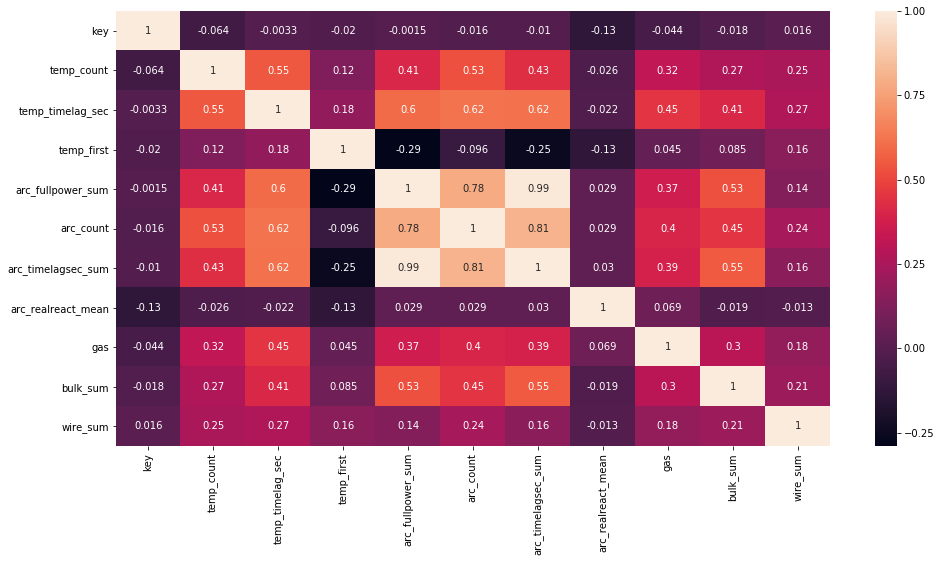

In [53]:
corrMatrix = features.corr()

plt.figure(figsize=(16, 8))
sns.heatmap(corrMatrix, annot=True)
plt.show()

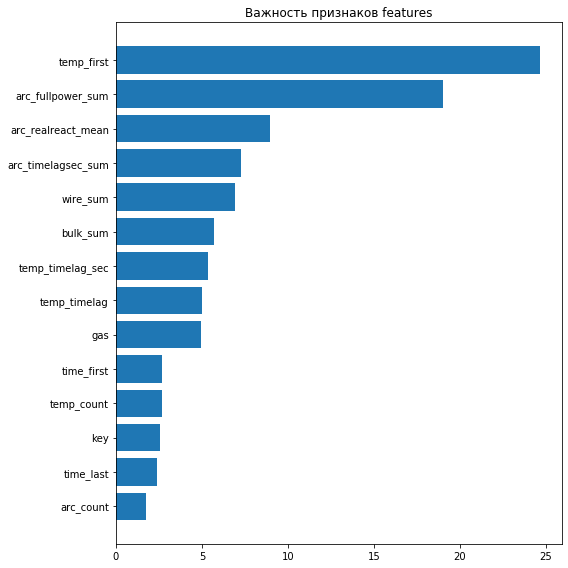

In [54]:
model_cb = cbr(loss_function = 'MAE', verbose=False, random_state=12345)
model_cb.fit(features, target)
feature_importance = model_cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title('Важность признаков features')
fig.tight_layout()
plt.show()

In [55]:
features.drop(['arc_count','key','time_last','time_first','temp_count','temp_timelag'], axis='columns',inplace=True)

Удаляем малозначительные признаки из наших фичей, а так же дублирующийся, по сути, *temp_timelag*

In [56]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=12345)

In [57]:
print('Количество строк в обучающей выборке:', len(target_train))
print('Количество строк в тестовой выборке:', len(target_test))

Количество строк в обучающей выборке: 1726
Количество строк в тестовой выборке: 576


Разбиваем на train и test в соотношении 75:25

In [58]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Промасштабируем признаки с помощью **StandartScaler**

## Обучение моделей <a name="part_4"></a>

In [59]:
cv = 3

In [60]:
model_lr = LinearRegression()
mae_lr = abs(cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_absolute_error',cv=cv).mean())
print(np.round(mae_lr,2))

6.52


Модель линейной регрессии, предсказуемо, дала самый слабый результат, идем дальше

In [61]:
model_rfr = RandomForestRegressor(random_state=12345)
mae_rfr = abs(cross_val_score(model_rfr, features_train, target_train, scoring='neg_mean_absolute_error',cv=cv).mean())
print(np.round(mae_rfr,2))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


6.43


In [61]:
params = {'n_estimators': range(10, 201, 10),
          'max_depth': range(1, 21, 2)}

grid = GridSearchCV(model_rfr, params, cv=cv, scoring='neg_mean_absolute_error')
grid.fit(features_train, target_train)

grid.best_params_

{'max_depth': 17, 'n_estimators': 160}

In [62]:
model_rfr = RandomForestRegressor(random_state=12345, max_depth=17, n_estimators=160)
mae_rfr = abs(cross_val_score(model_rfr, features_train, target_train, scoring='neg_mean_absolute_error',cv=cv).mean())
print(np.round(mae_rfr,2))

6.08


Попытка использовать ансамблевую модель. Сначала на дефолтных параметрах, затем немного усовершенствованная с помощью **GridSearch**. Большого прироста точности это не дало, но результат не самый плохой

In [63]:
model_cb = cbr(loss_function = 'MAE', verbose=False, random_state=12345)
mae_cb = abs(cross_val_score(model_cb, features_train, target_train, 
                             scoring='neg_mean_absolute_error', cv=cv).mean())

print(np.round(mae_cb,2))

5.83


In [64]:
params = {'metric':'mae',
          'random_seed':12345,
          'verbose':0,
          'force_col_wise':True
}
    
d_train = lgb.Dataset(features_train, target_train)
mae_lb = lgb.cv(params,d_train,nfold=cv)

print(np.round(np.mean(mae_lb['l1-mean']),2))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


6.08


LGBM бустинг так же дал очень хороший результат, но CatBoost все-таки лучше. Попробовал GridSearch, но очень долго, поэтому дефолт

In [65]:
print('Значение МАЕ на тестовой выборке')

model_cb = cbr(loss_function = 'MAE', verbose=False, random_state=12345)
model_cb.fit(features_train,target_train)
predicted_test_cb = model_cb.predict(features_test)
mae_test = mean_absolute_error(target_test, predicted_test_cb)
print(np.round(mae_test,2))
print()

Значение МАЕ на тестовой выборке
5.77



И вот итог нашей работы. **CatBoost** показал МАЕ на тестовой выборке, равный 5.77, условие задачи выполнено